In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from helpers import compute_proportion_of_votes
from sklearn.model_selection import train_test_split, KFold

sns.set()

2022-10-22 11:54:26.295466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 11:54:26.396854: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-22 11:54:26.400209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/olivier/miniconda3/lib:/home/olivier/miniconda3/lib:
2022-10-22 11:54:26.400218: I tensorf

## Goal of the notebook

We want to predict second-round results from first-round results. To do so will use a neural network.

## Load data

In [2]:
# load election results
df_t1 = pd.read_csv('../data/presidentielle_t1.csv', low_memory=False)
df_t2 = pd.read_csv('../data/presidentielle_t2.csv', low_memory=False)

id_columns = [
    'CodeDepartement',
    'NomDepartement',
    'CodeCirconscription',
    'NomCirconscription',
    'CodeCommune',
    'NomCommune',
    'CodeBureauVote',
    'Inscrits']

choices_t1 = [
    'No_One',
    'Arthaud',
    'Roussel',
    'Macron',
    'Lassalle',
    'Le_Pen',
    'Zemmour',
    'Melenchon',
    'Hidalgo',
    'Jadot',
    'Pecresse',
    'Poutou',
    'Dupont_Aignan']

choices_t2 = [
    'No_One',
    'Macron',
    'Le_Pen']

# filter out voting stations with no choices
mask = ((df_t1["Votants"] - df_t1["No_One"] >= 30) & 
    (df_t2["Votants"] - df_t2["No_One"] >= 30))
df_t1 = df_t1.loc[mask, :].reset_index(drop=True)
df_t2 = df_t2.loc[mask, :].reset_index(drop=True)

# compute proportions
prop_t1 = compute_proportion_of_votes(df_t1, choices_t1)
prop_t2 = compute_proportion_of_votes(df_t2, choices_t2)

## Choosing a model

We will use k-fold cross-validation to identify the number of layers and neurons per layer. We first define a function that allows us to create a neural network using TensorFlow.

In [3]:
def create_model(
        input_shape: int,
        output_shape: int,
        hidden_shape: int,
        hidden_n_layers: int,
        batch_norm: bool = False,
        activation="selu",
        kernel_initializer='lecun_normal',
        optimizer="adam",
        loss=tf.keras.losses.kl_divergence):
        
    '''Create neural network model.'''

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(
        input_shape,
        activation=activation,
        kernel_initializer=kernel_initializer))

    if batch_norm:
        model.add(tf.keras.layers.BatchNormalization())

    for _ in range(hidden_n_layers):
        model.add(tf.keras.layers.Dense(
            hidden_shape,
            activation=activation,
            kernel_initializer=kernel_initializer))
        if batch_norm:
            model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Dense(
        output_shape,
        activation="softmax",
        kernel_initializer=kernel_initializer))

    model.compile(optimizer=optimizer, loss=loss)

    return model


We now set the hyperparameters of the model that we will be testing. 

- `hidden_shape` is the number of neurons per layer
- `hidden_n_layer` is the number of hidden layers

In [4]:
model_params = np.meshgrid(
    [5, 20, 50],
    [1, 3, 5],
    [False]
)
model_params = np.array(model_params).T.reshape(-1, 3)
model_params = pd.DataFrame(
    model_params,
    columns=["hidden_shape", "hidden_n_layers", "batch_norm"])
model_params

hidden_shape  hidden_n_layers  batch_norm
0             5                1           0
1             5                3           0
2             5                5           0
3            20                1           0
4            20                3           0
5            20                5           0
6            50                1           0
7            50                3           0
8            50                5           0

We now run the 5-fold cross-validation.

In [5]:
train_prop_t1, test_prop_t1, train_prop_t2, test_prop_t2 = train_test_split(
    prop_t1, prop_t2, test_size=.2, random_state=63)

nkf = 5
results = np.zeros((model_params.shape[0], nkf))
kf = KFold(nkf, random_state=63, shuffle=True)

for kf_idx, (train_idx, val_idx) in enumerate(kf.split(train_prop_t1)):
    for param_idx in range(model_params.shape[0]):

        hidden_shape = model_params["hidden_shape"][param_idx]
        hidden_n_layers = model_params["hidden_n_layers"][param_idx]
        batch_norm = model_params["batch_norm"][param_idx]

        model = create_model(
            input_shape=prop_t1.shape[1],
            output_shape=prop_t2.shape[1],
            hidden_shape=hidden_shape,
            hidden_n_layers=hidden_n_layers,
            batch_norm=batch_norm)

        model.fit(
            x=train_prop_t1.iloc[train_idx, :],
            y=train_prop_t2.iloc[train_idx, :],
            epochs=10,
            verbose=0)

        error = model.evaluate(
            x=train_prop_t1.iloc[val_idx, :],
            y=train_prop_t2.iloc[val_idx, :],
            verbose=0)
        results[param_idx, kf_idx] = error

        print(f'{kf_idx=}, {param_idx=} {error=:.4f}')


2022-10-22 11:54:27.610197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/olivier/miniconda3/lib:/home/olivier/miniconda3/lib:
2022-10-22 11:54:27.610217: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-22 11:54:27.610231: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-10-22 11:54:27.610424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


kf_idx=0, param_idx=0 error=0.0033
kf_idx=0, param_idx=1 error=0.0034
kf_idx=0, param_idx=2 error=0.0034
kf_idx=0, param_idx=3 error=0.0032
kf_idx=0, param_idx=4 error=0.0032
kf_idx=0, param_idx=5 error=0.0035
kf_idx=0, param_idx=6 error=0.0035
kf_idx=0, param_idx=7 error=0.0033
kf_idx=0, param_idx=8 error=0.0032
kf_idx=1, param_idx=0 error=0.0033
kf_idx=1, param_idx=1 error=0.0033
kf_idx=1, param_idx=2 error=0.0038
kf_idx=1, param_idx=3 error=0.0032
kf_idx=1, param_idx=4 error=0.0031
kf_idx=1, param_idx=5 error=0.0032
kf_idx=1, param_idx=6 error=0.0032
kf_idx=1, param_idx=7 error=0.0031
kf_idx=1, param_idx=8 error=0.0032
kf_idx=2, param_idx=0 error=0.0033
kf_idx=2, param_idx=1 error=0.0033
kf_idx=2, param_idx=2 error=0.0034
kf_idx=2, param_idx=3 error=0.0033
kf_idx=2, param_idx=4 error=0.0036
kf_idx=2, param_idx=5 error=0.0035
kf_idx=2, param_idx=6 error=0.0033
kf_idx=2, param_idx=7 error=0.0032
kf_idx=2, param_idx=8 error=0.0032
kf_idx=3, param_idx=0 error=0.0033
kf_idx=3, param_idx=

We look at the distribution of errors for each model. There does not seem to be a significant difference in terms of prediction error between the models.

<AxesSubplot: xlabel='param_index', ylabel='value'>

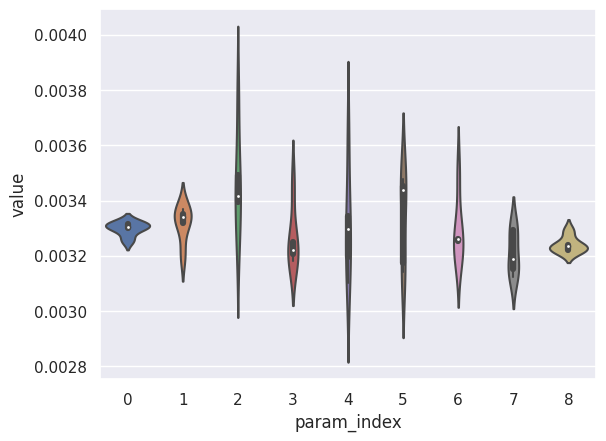

In [6]:
model_params_results = pd.concat([model_params, pd.DataFrame(results)], axis=1)
model_params_results["param_index"] = range(model_params_results.shape[0])

model_params_results_melt = model_params_results.melt(
    id_vars=list(model_params.columns)+["param_index"])

sns.violinplot(model_params_results_melt, x="param_index", y="value")


We look at the median error for each model. We that 3 layers with 50 neurons per layer seem to give the best results.

In [7]:
(model_params_results_melt
    .groupby(list(model_params.columns))["value"]
    .median()
    .sort_values())

hidden_shape  hidden_n_layers  batch_norm
50            3                0             0.003187
20            1                0             0.003219
50            5                0             0.003235
              1                0             0.003261
20            3                0             0.003296
5             1                0             0.003303
              3                0             0.003341
              5                0             0.003415
20            5                0             0.003438
Name: value, dtype: float64

## Estimating test error

We now estimate the test error of this model.

In [9]:
model = create_model(
    input_shape=prop_t1.shape[1],
    output_shape=prop_t2.shape[1],
    hidden_shape=50,
    hidden_n_layers=3,
    batch_norm=False)
    
history = model.fit(
    x=train_prop_t1, 
    y=train_prop_t2,
    epochs=50, 
    validation_split=.1,
    verbose=0)

In [10]:
model.evaluate(
    x=test_prop_t1,
    y=test_prop_t2,
    verbose=0)

0.0029534995555877686

<AxesSubplot: >

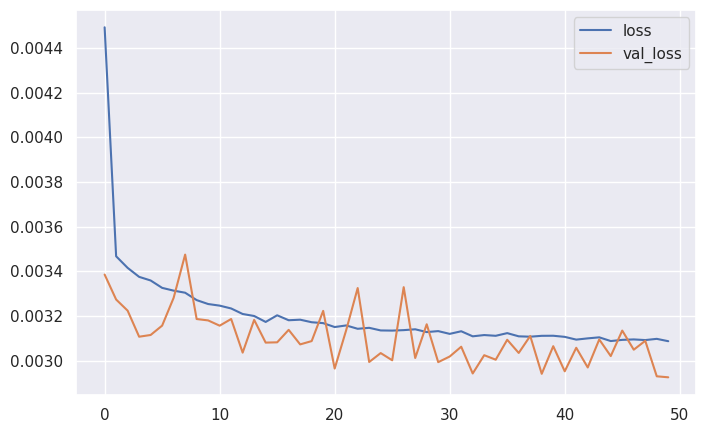

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

## Fit model with all the data

We now fit the model with all the data.

In [12]:
model = create_model(
    input_shape=prop_t1.shape[1],
    output_shape=prop_t2.shape[1],
    hidden_shape=50,
    hidden_n_layers=3,
    batch_norm=False)
    
history = model.fit(
    x=prop_t1, 
    y=prop_t2,
    epochs=50, 
    validation_split=.1,
    verbose=0)

<AxesSubplot: >

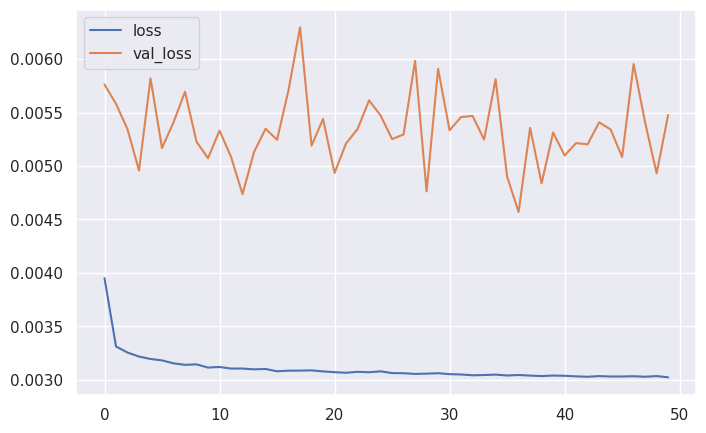

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

## Looking at predictions of model

We look at observed values against predicted values and overall see a good correlation between observed and predicted proportions.

In [15]:
# We retrieve predictions
prop_t2_hat = pd.DataFrame(model.predict(prop_t1, verbose=0))
prop_t2_hat.columns = prop_t2.columns
prop_t2_all = pd.merge(prop_t2, prop_t2_hat,
                       left_index=True, right_index=True,
                       suffixes=['_Observed', '_Predicted'])
prop_t2_all = pd.merge(df_t1[id_columns], prop_t2_all,
                       left_index=True, right_index=True)

# We compute the pointwise error per voting station
def error(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = tf.keras.backend.clip(y_true, tf.keras.backend.epsilon(), 1)
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1)
    return tf.math.abs(tf.math.log(y_true / y_pred))

for choice in choices_t2:
    prop_t2_all[f'{choice}_Residual'] = error(
        prop_t2_all[f'{choice}_Observed'], 
        prop_t2_all[f'{choice}_Predicted'])

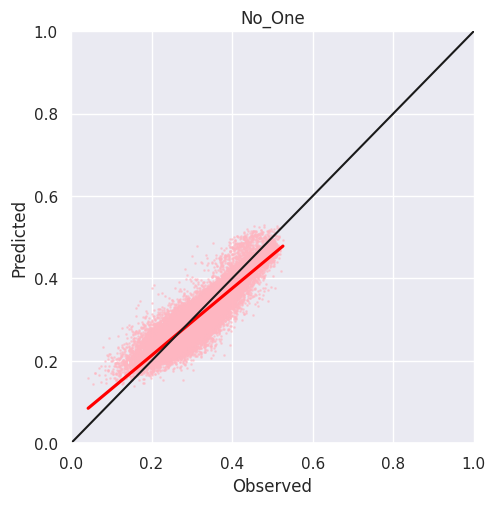

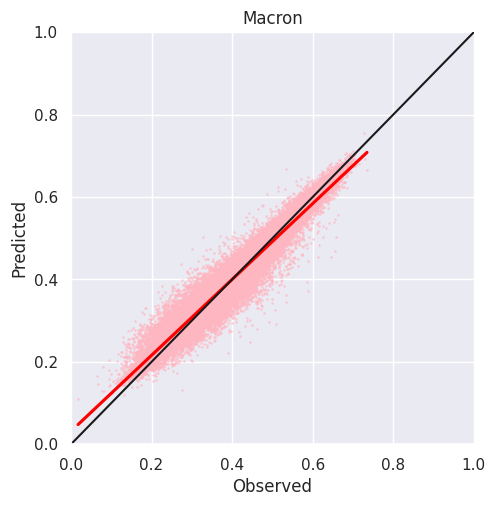

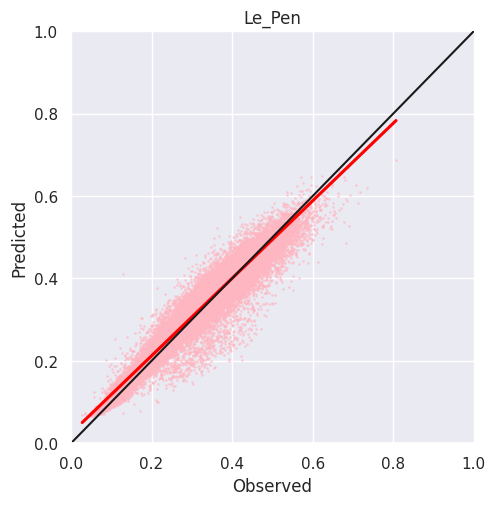

In [16]:
for choice in choices_t2:
    sns.lmplot(data=prop_t2_all,
               x=f'{choice}_Observed',
               y=f'{choice}_Predicted',
               line_kws={'color': 'red'},
               scatter_kws={'s': 1, 'color': '#ffb6c1', 'alpha': .5})
    plt.axline(xy1=(0, 0), slope=1, color='k')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title(choice)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')

## Relation between the first and second round

We create hypothetical results using our trained model. For any voting station of the first round, we artificially deflate or inflate the results of a specific candidate, and use this new proportion to predict the second results using our model. This allows us to infer how the ballots of one first-round candidate are transferred to a second-round candidate.

We first define functions that allow us to study this relationship.

In [17]:
def predict_hypothetical_results(station_index, prop_t1, model):

    aux = []
    original_prop_t1 = prop_t1.iloc[station_index].copy()
    choice_prop_t1 = np.linspace(0, 30, 501)
    for choice in choices_t1:
        new_prop_t1 = np.zeros(
            (choice_prop_t1.shape[0], original_prop_t1.shape[0]))
        for i in range(new_prop_t1.shape[0]):
            x = original_prop_t1.copy()
            x[choice] = choice_prop_t1[i]
            x = x/sum(x)
            new_prop_t1[i, :] = x

        new_prop_t1 = pd.DataFrame(new_prop_t1, columns=prop_t1.columns)
        new_prop_t2_hat = model.predict(new_prop_t1, verbose=0)
        new_prop_t2_hat = pd.DataFrame(
            new_prop_t2_hat, columns=prop_t2.columns)
        new_prop_t2_hat['FirstRoundProportion'] = new_prop_t1[choice]
        new_prop_t2_hat['FirstRoundCandidate'] = choice
        aux.append(new_prop_t2_hat)

    new_prop_t2_hat = pd.concat(aux, axis=0)
    return new_prop_t2_hat


def plot_hypothetical_results(new_prop_t2_hat, station_index,
                              df_t1,
                              prop_t1, prop_t2,
                              palette=['grey', 'darkred', 'darkblue']):

    data = new_prop_t2_hat.melt(id_vars=['FirstRoundCandidate',
                                        'FirstRoundProportion'])
    data['variable'] = data['variable'].str.replace('_', ' ')
    data['FirstRoundCandidate'] = (data['FirstRoundCandidate'].
                                str.
                                replace('_', ' '))

    commune = df_t1.iloc[station_index]['NomCommune']
    department = df_t1.iloc[station_index]['NomDepartement']
    station = df_t1.iloc[station_index]['CodeBureauVote']

    g = sns.FacetGrid(data=data,
                    col='FirstRoundCandidate', col_wrap=3)
    g.map_dataframe(sns.lineplot,
                    x='FirstRoundProportion', y='value',
                    hue='variable', palette=palette)
    g.set_xlabels(f'1st Round')
    g.set_ylabels(f'2nd Round')
    g.set_titles(col_template='{col_name}')
    g.fig.subplots_adjust(top=0.94)
    g.fig.suptitle(f'{commune}, {department}, {station}')
    g.axes[0].legend()
    for i, ax in enumerate(g.axes):
        ax.hlines(prop_t2.iloc[station_index], xmin=0, xmax=1,
                color=palette, linestyles='dashed', linewidths=.5)
        ax.vlines(prop_t1.iloc[station_index, i], ymin=0, ymax=1,
                color='k', linestyles='dashed', linewidths=.5)


We now plot results for 15 randomly chosen voting stations. 

We see two consistent trends:
- voters of Le Pen, Zémmour, and Dupont-Aignan tend to give their ballots to Le Pen;
- voters of Macron, Jadot, and Hidalgo tend to give their ballots to Macron;
- it's not possible to know who voters of Lassalle vote for in the second round.

There are more complex trends for Mélenchon, Roussel, and Poutou voters who, depending on the station, either transfer their ballot to Macron or decide not to choose any candidate. 

A curious result that may show the limits of the analysis concerns voters of Arthaud. It appears that these voters transfer their ballot to Le Pen, which is unexpected given that these two candidates are opposites on the political spectrum.

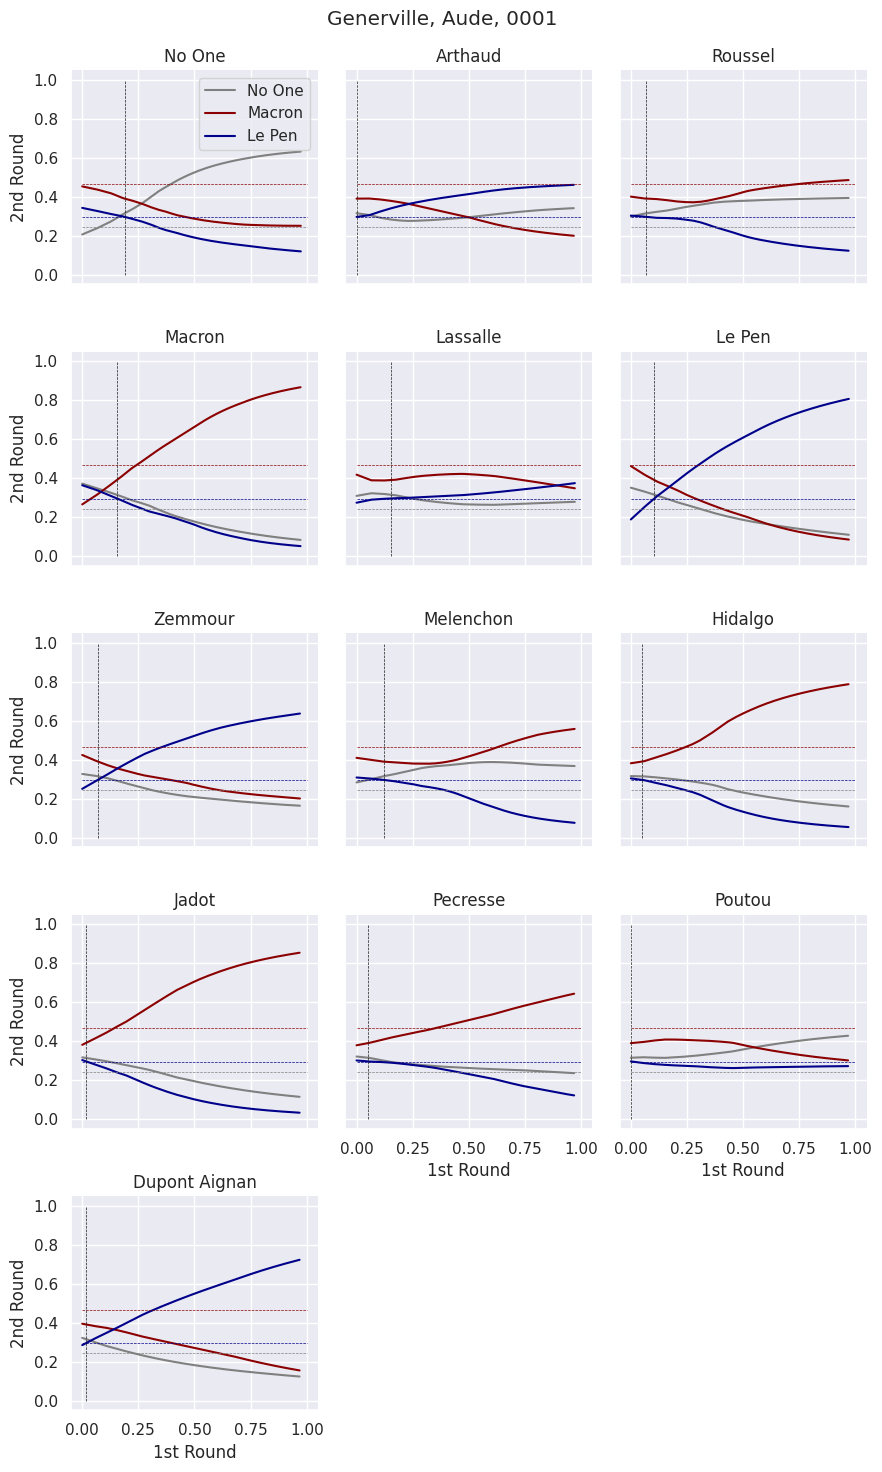

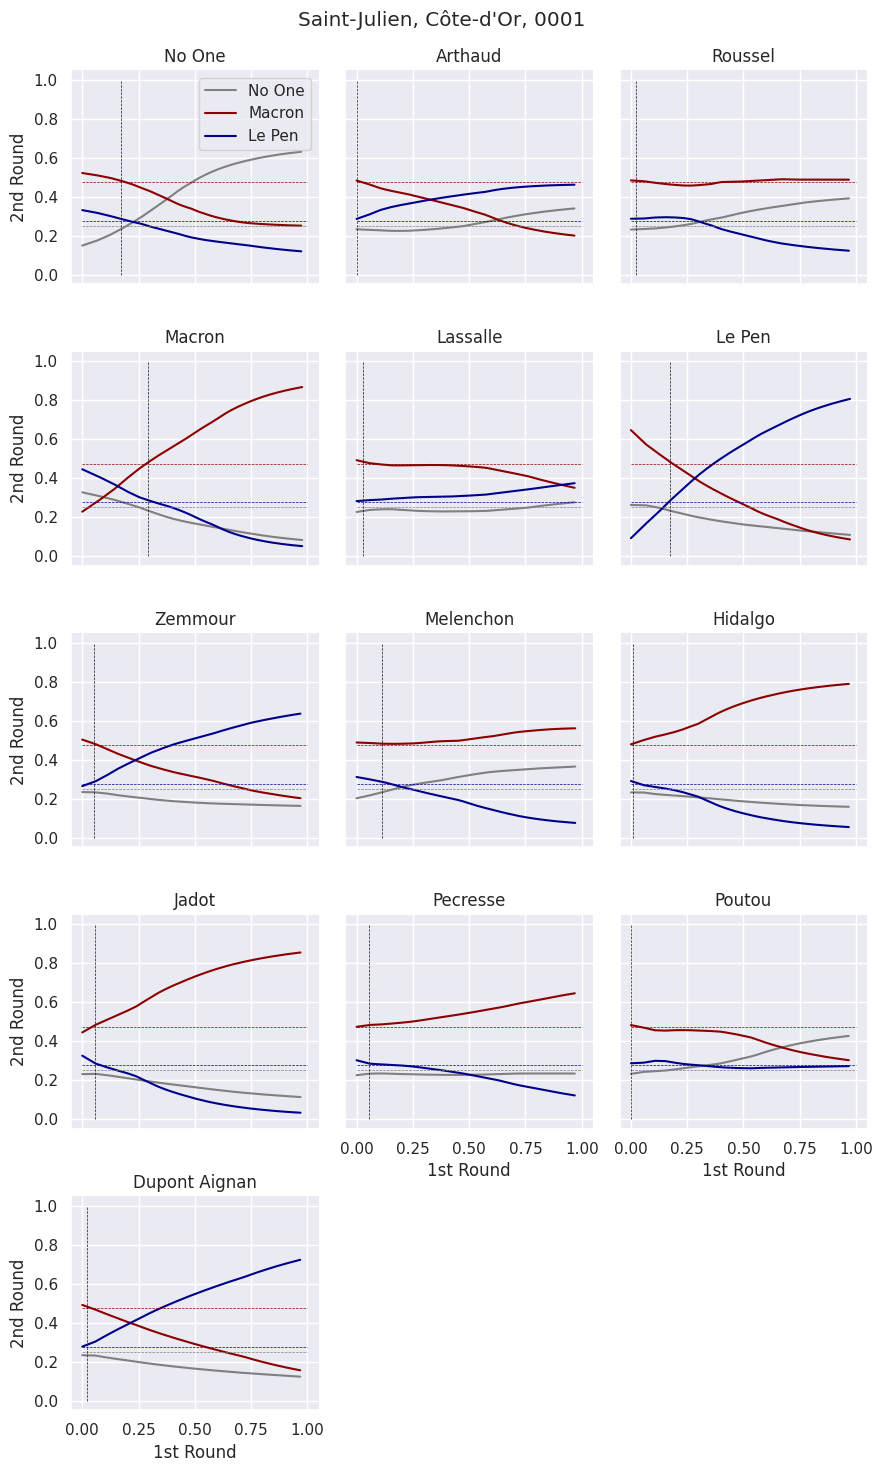

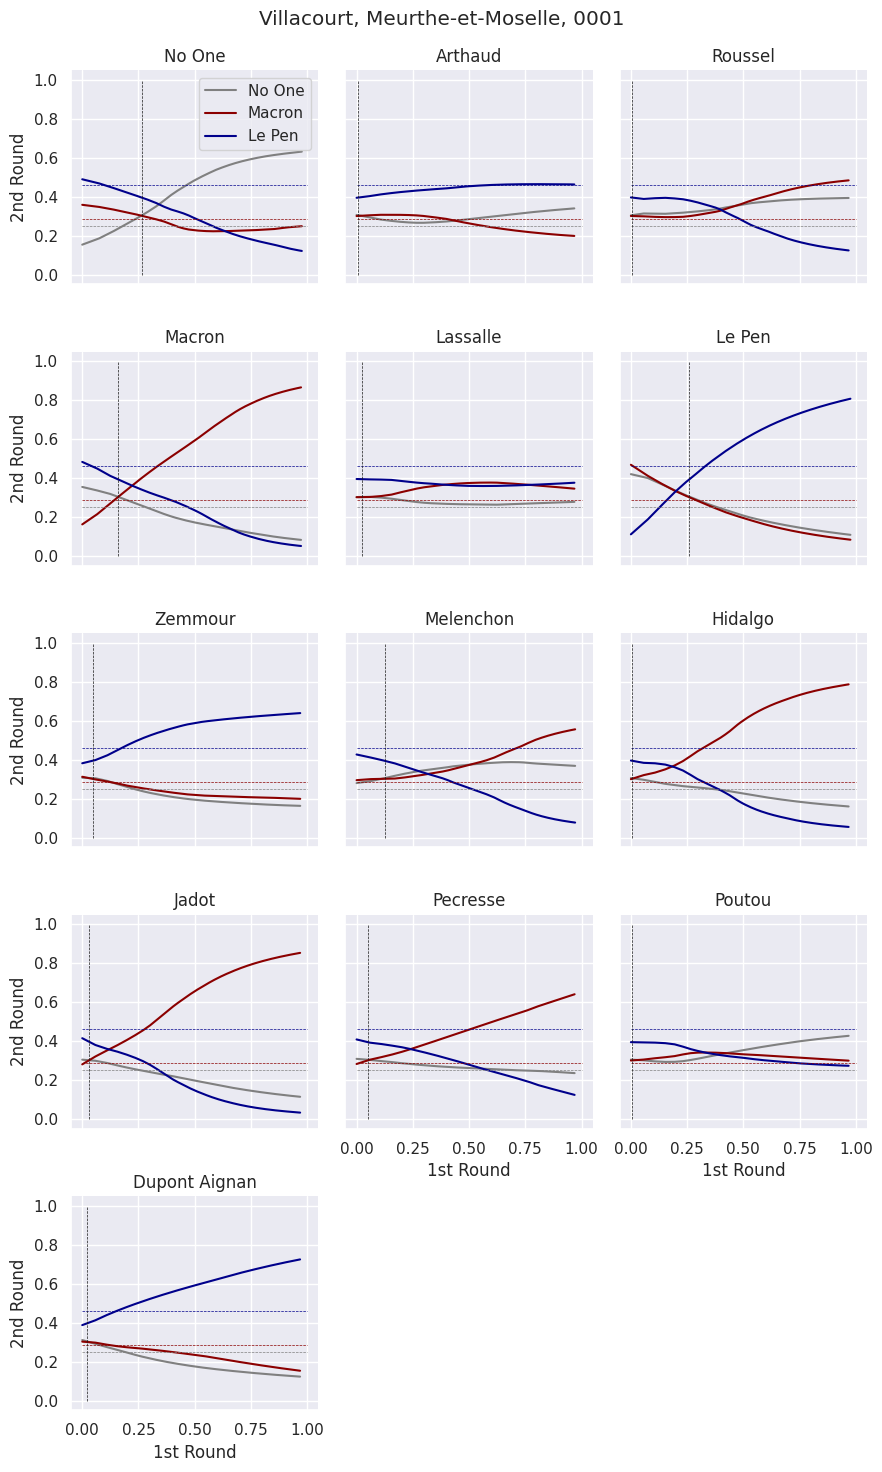

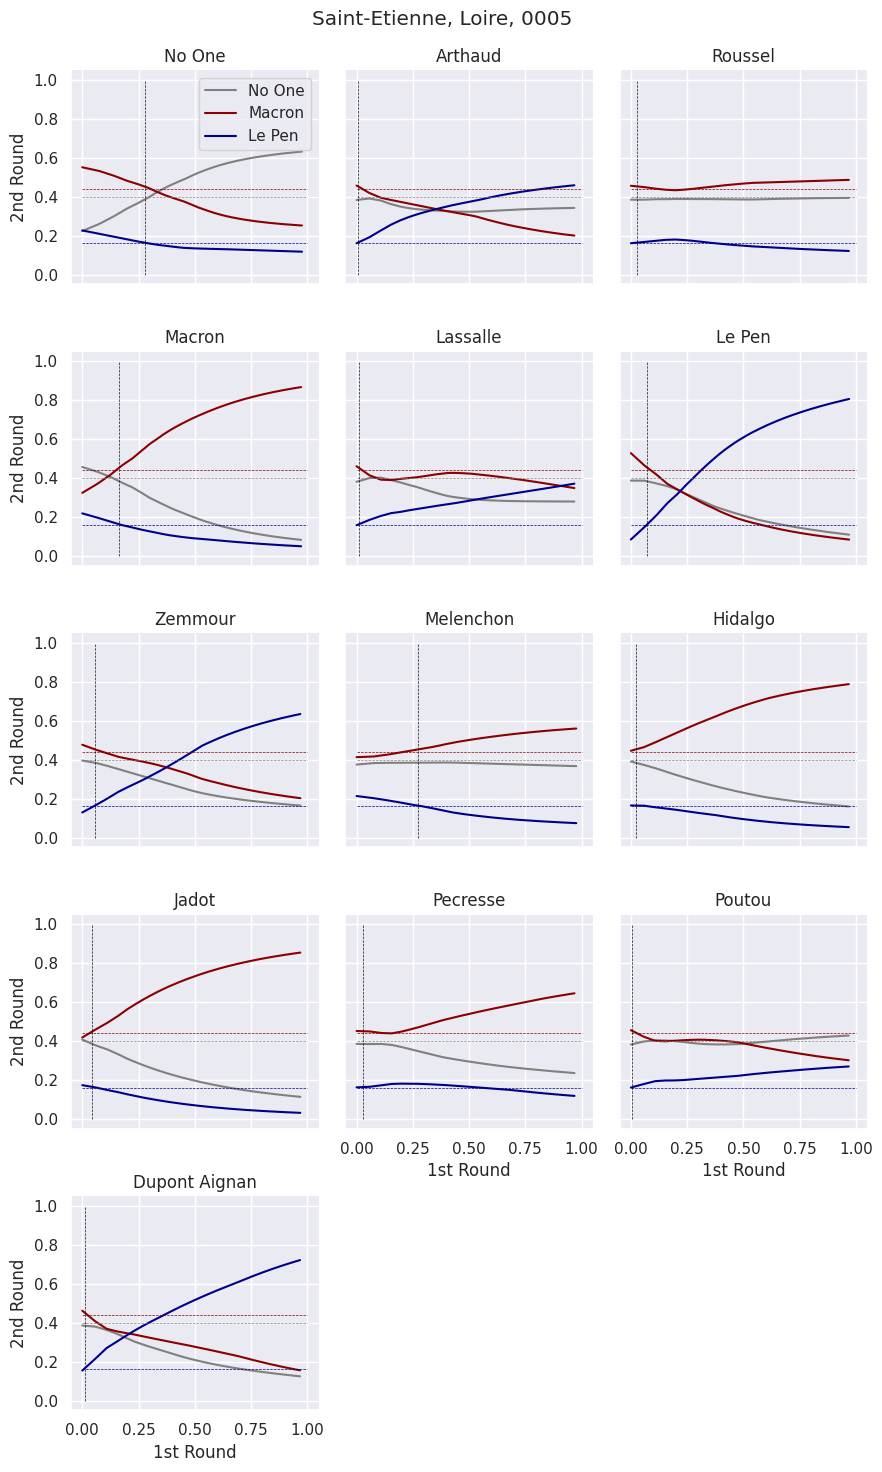

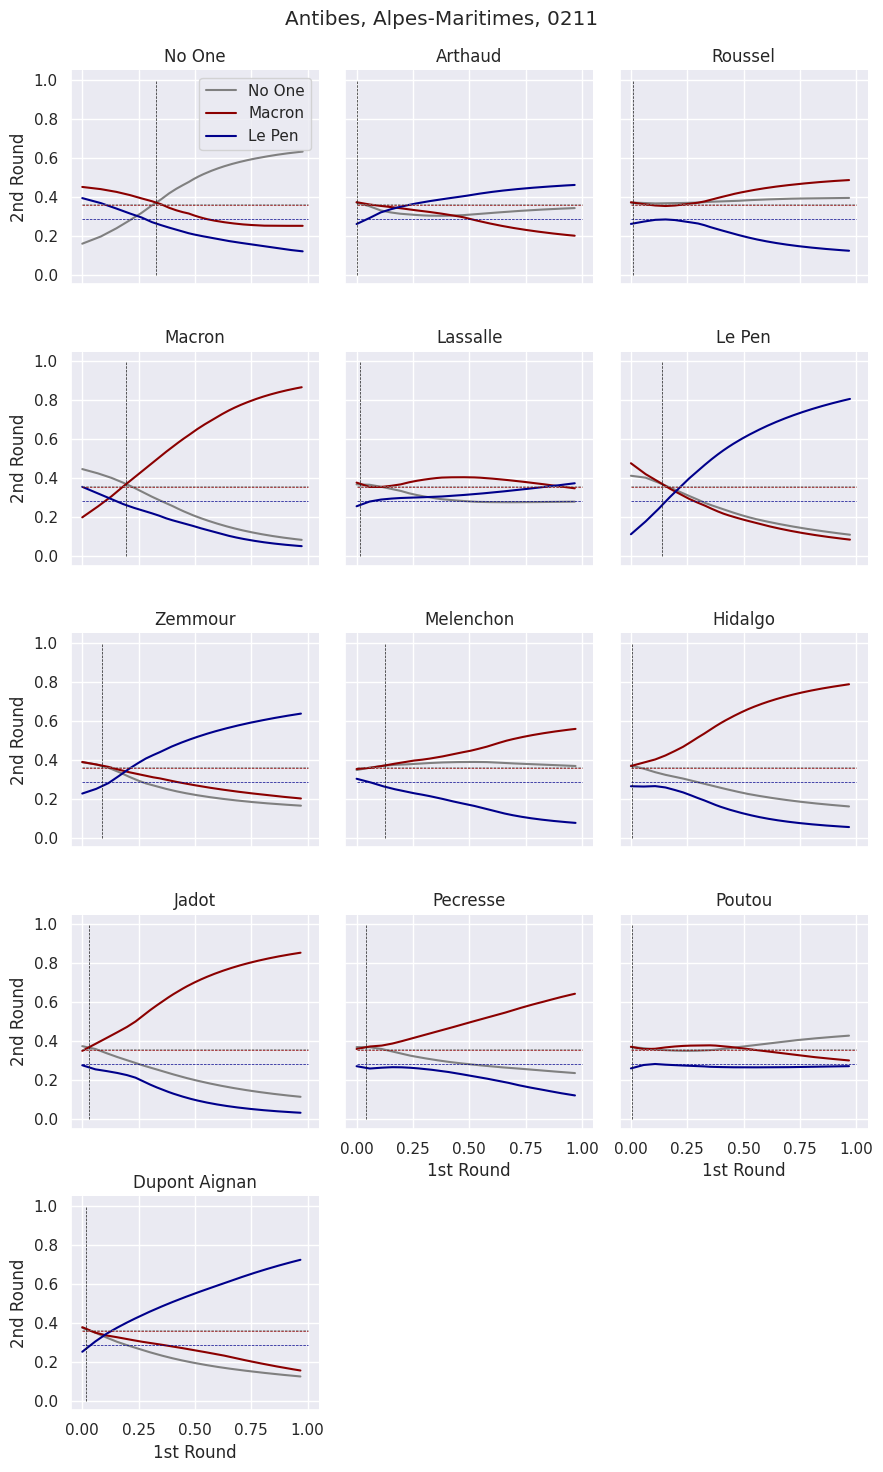

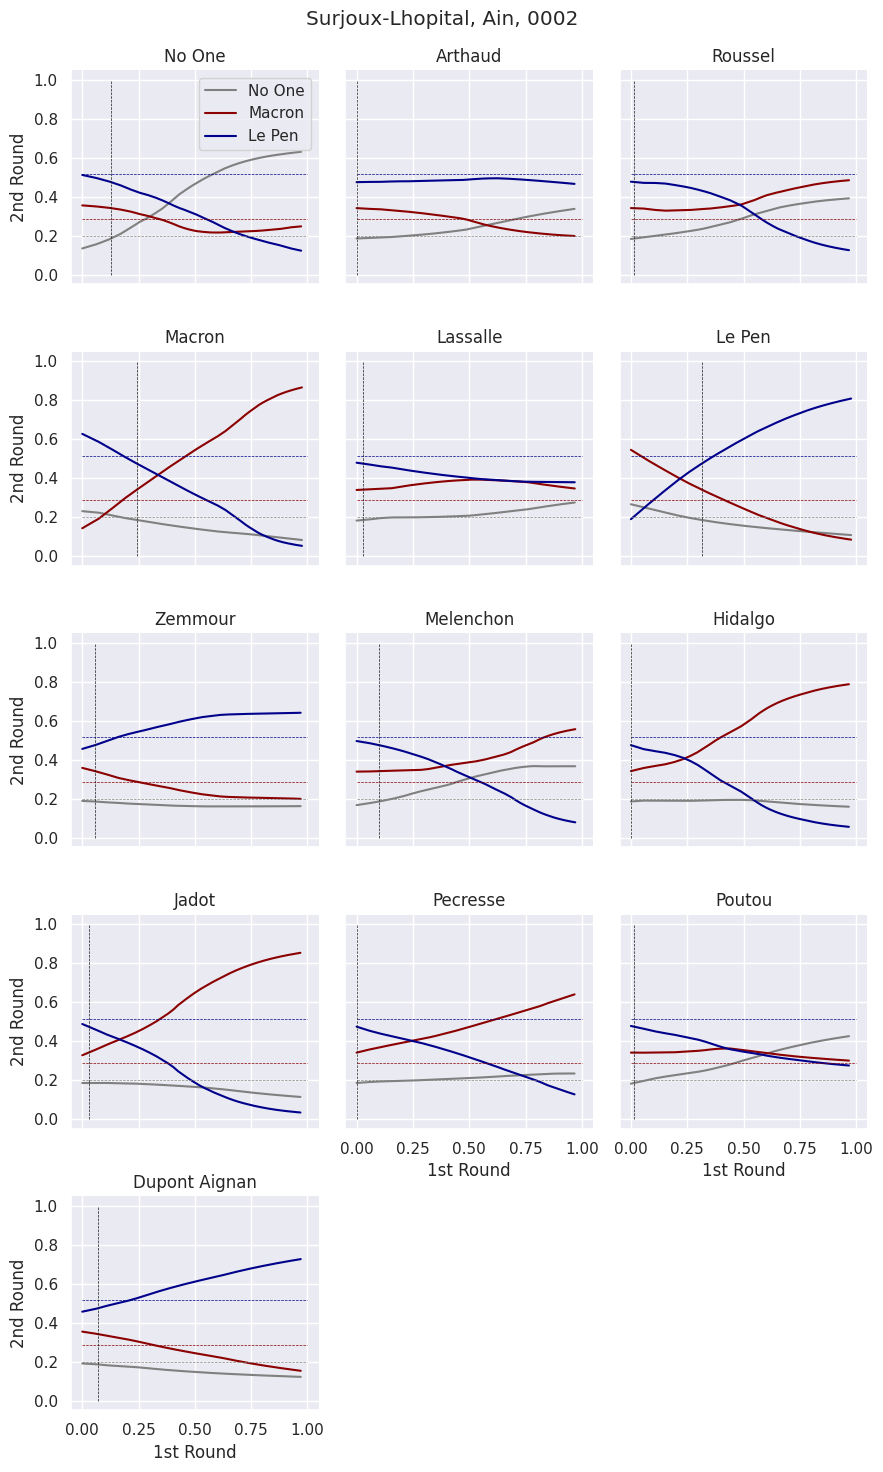

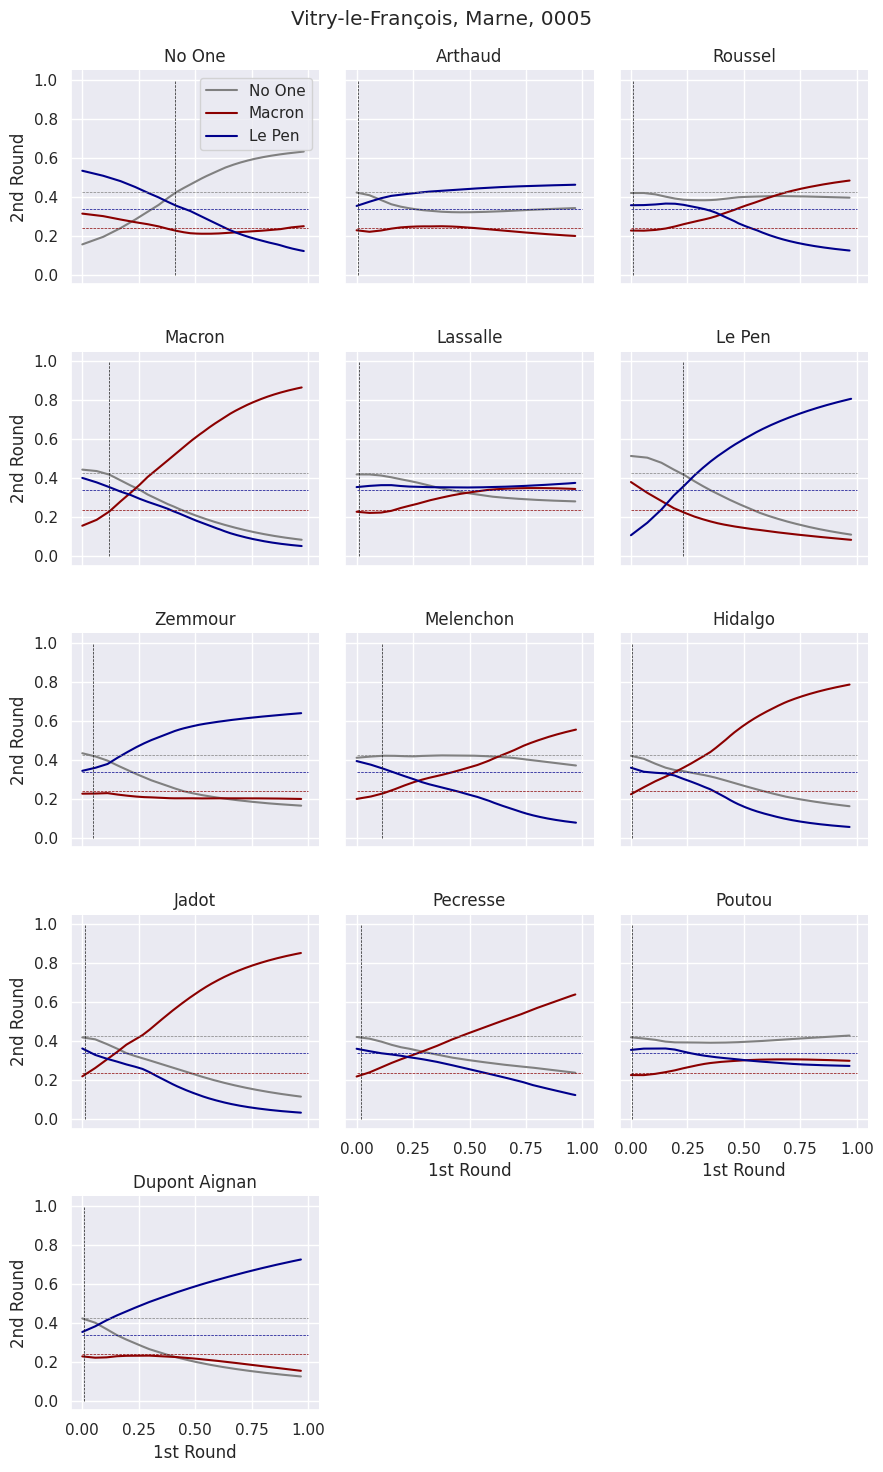

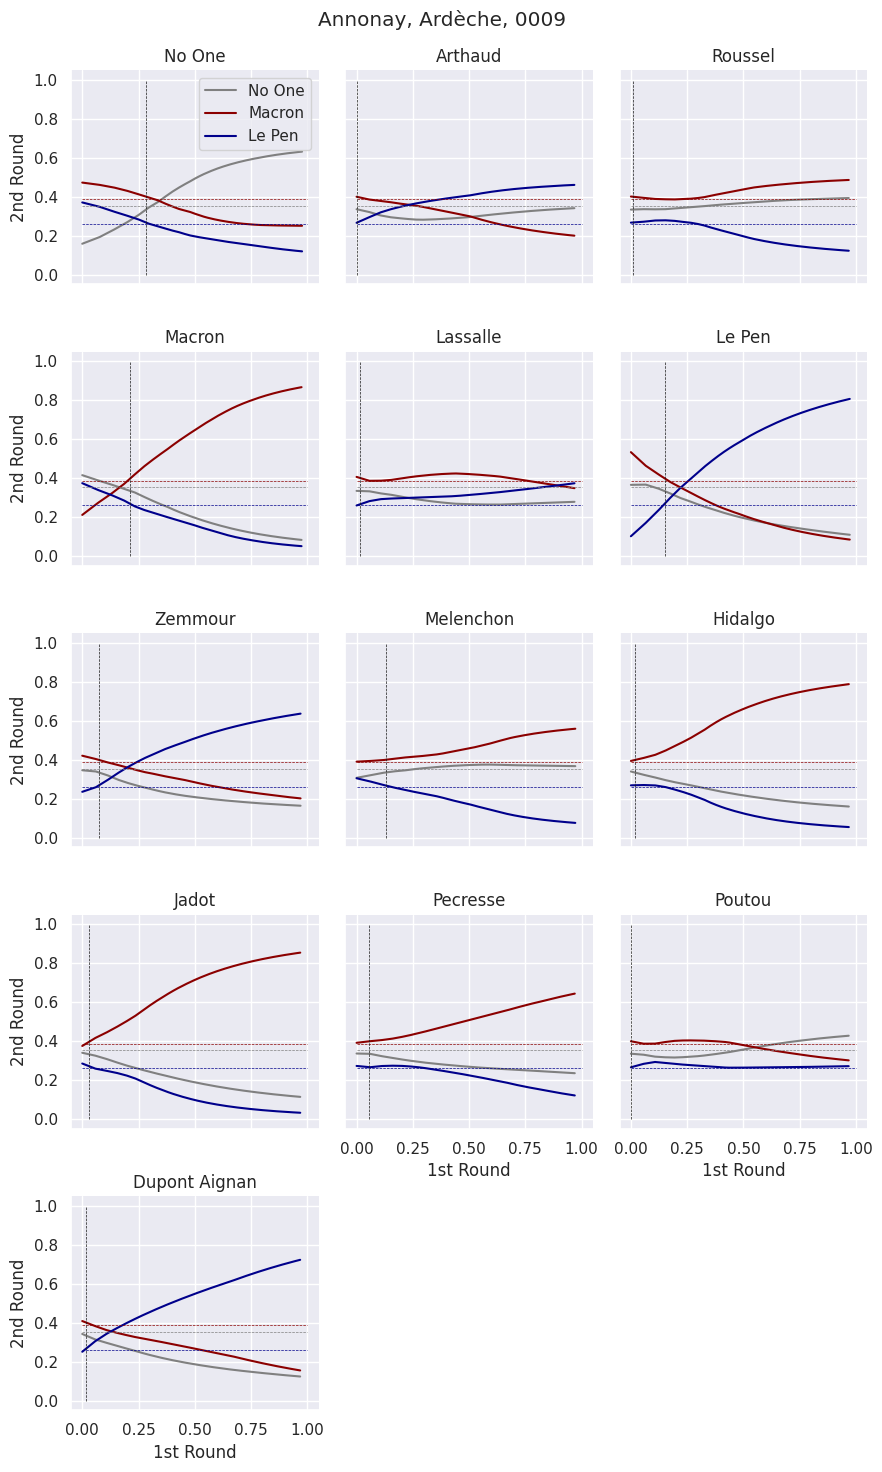

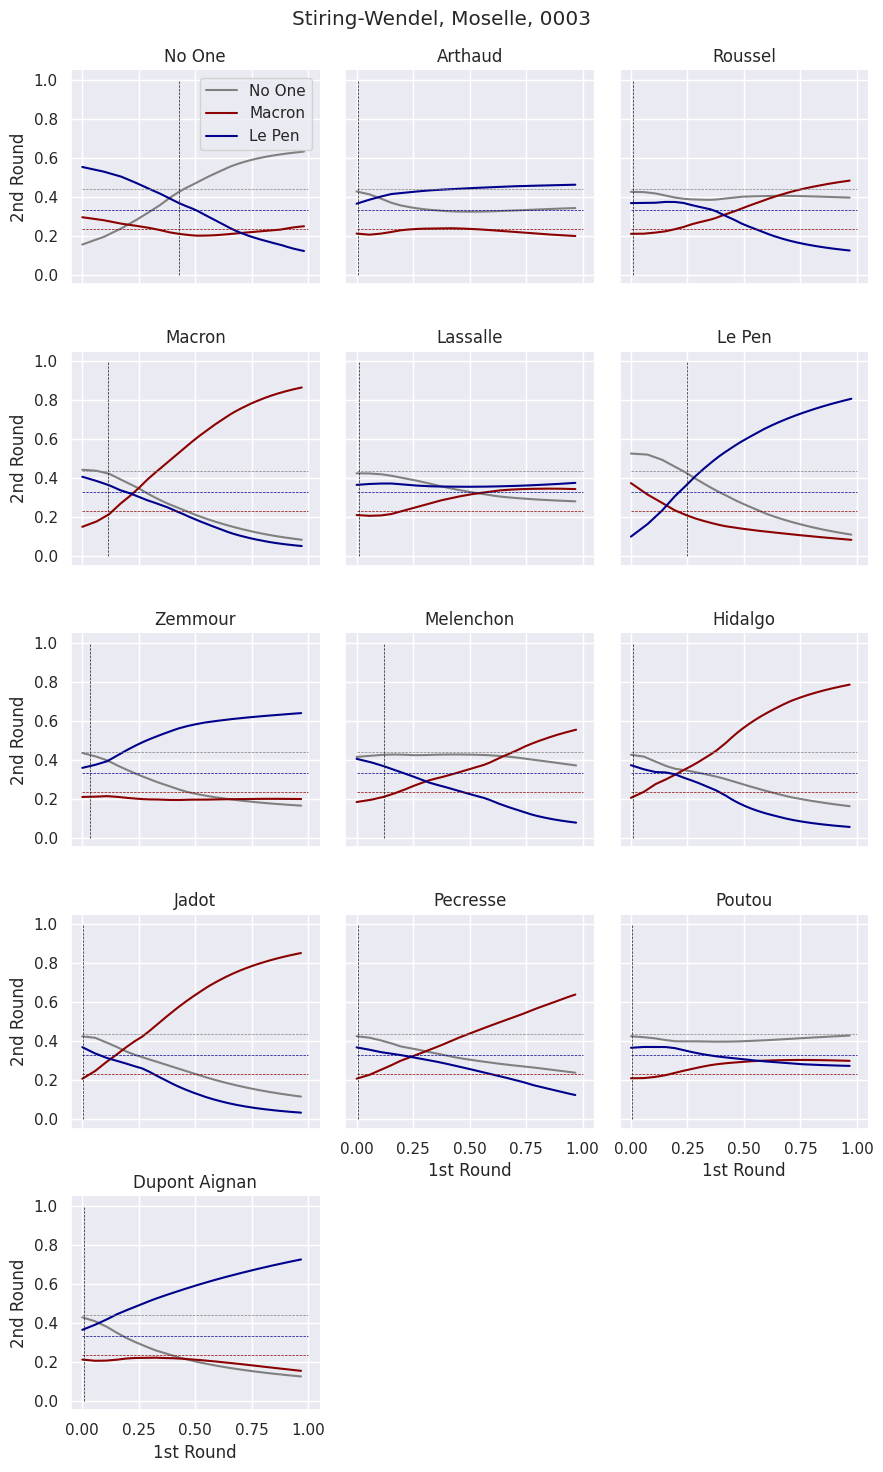

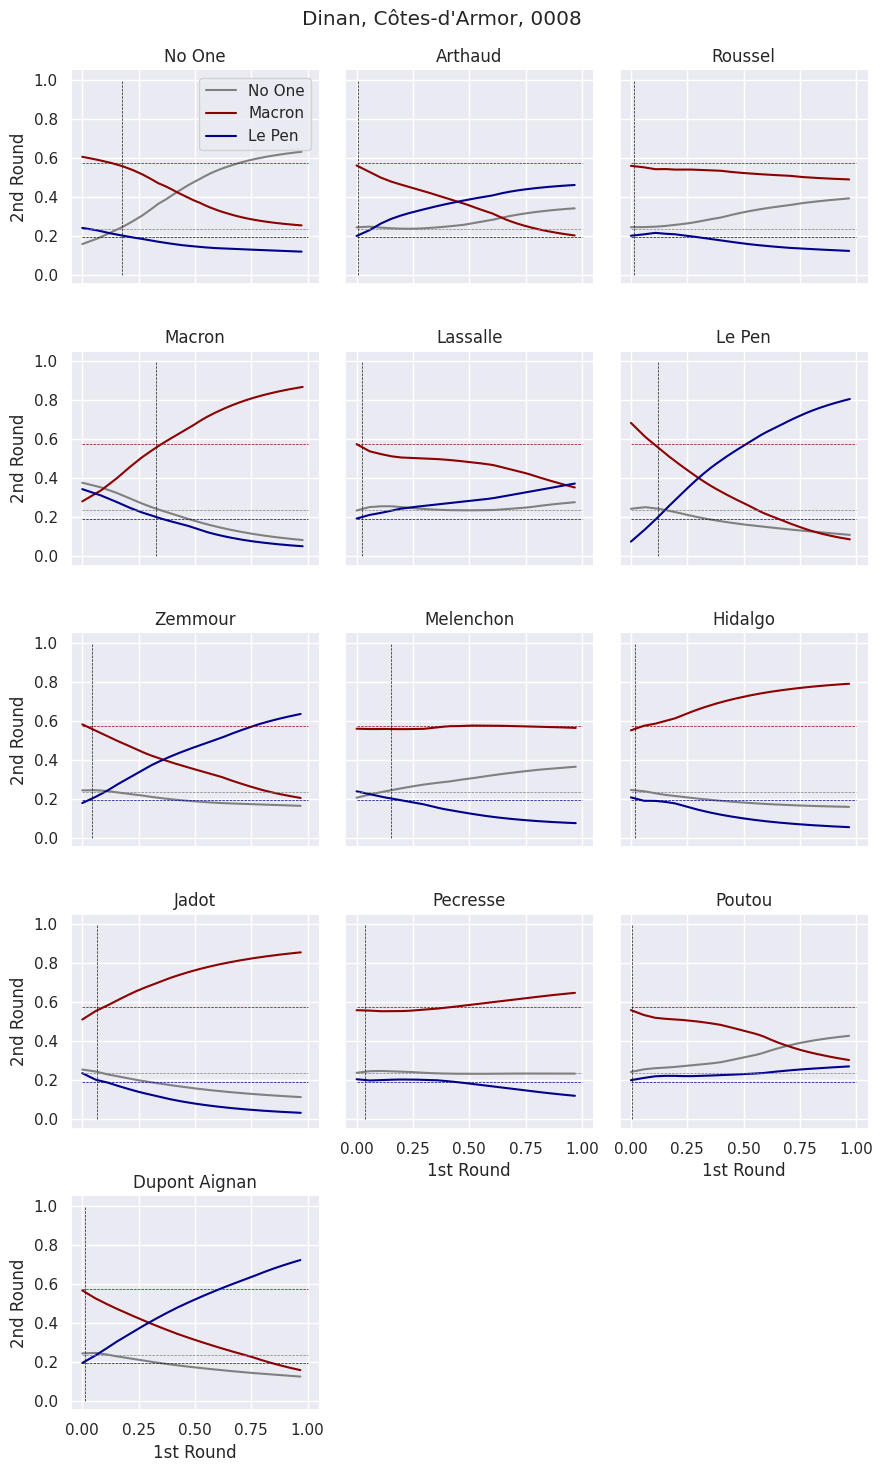

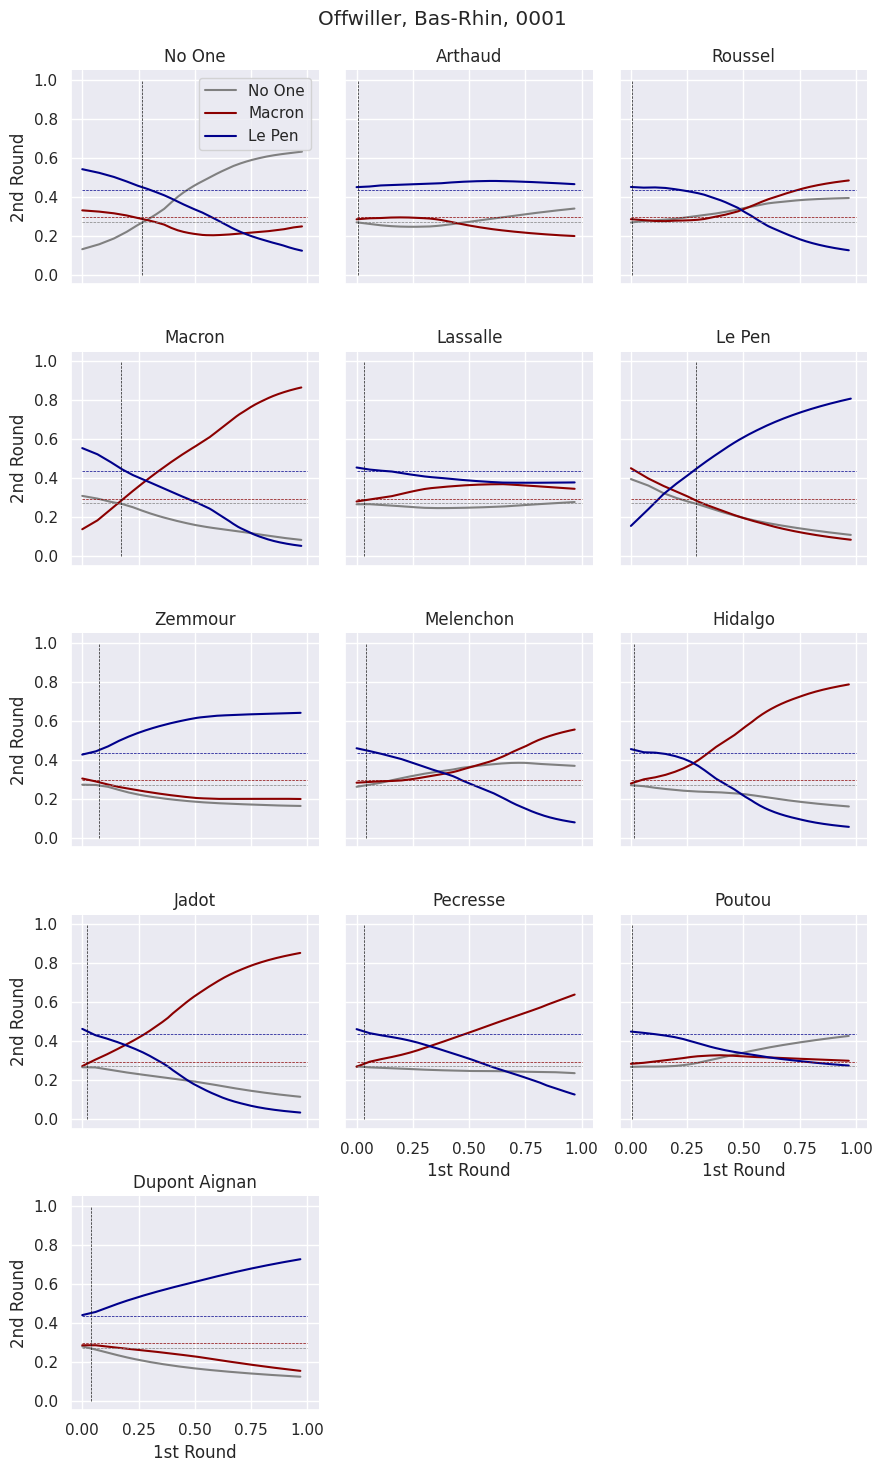

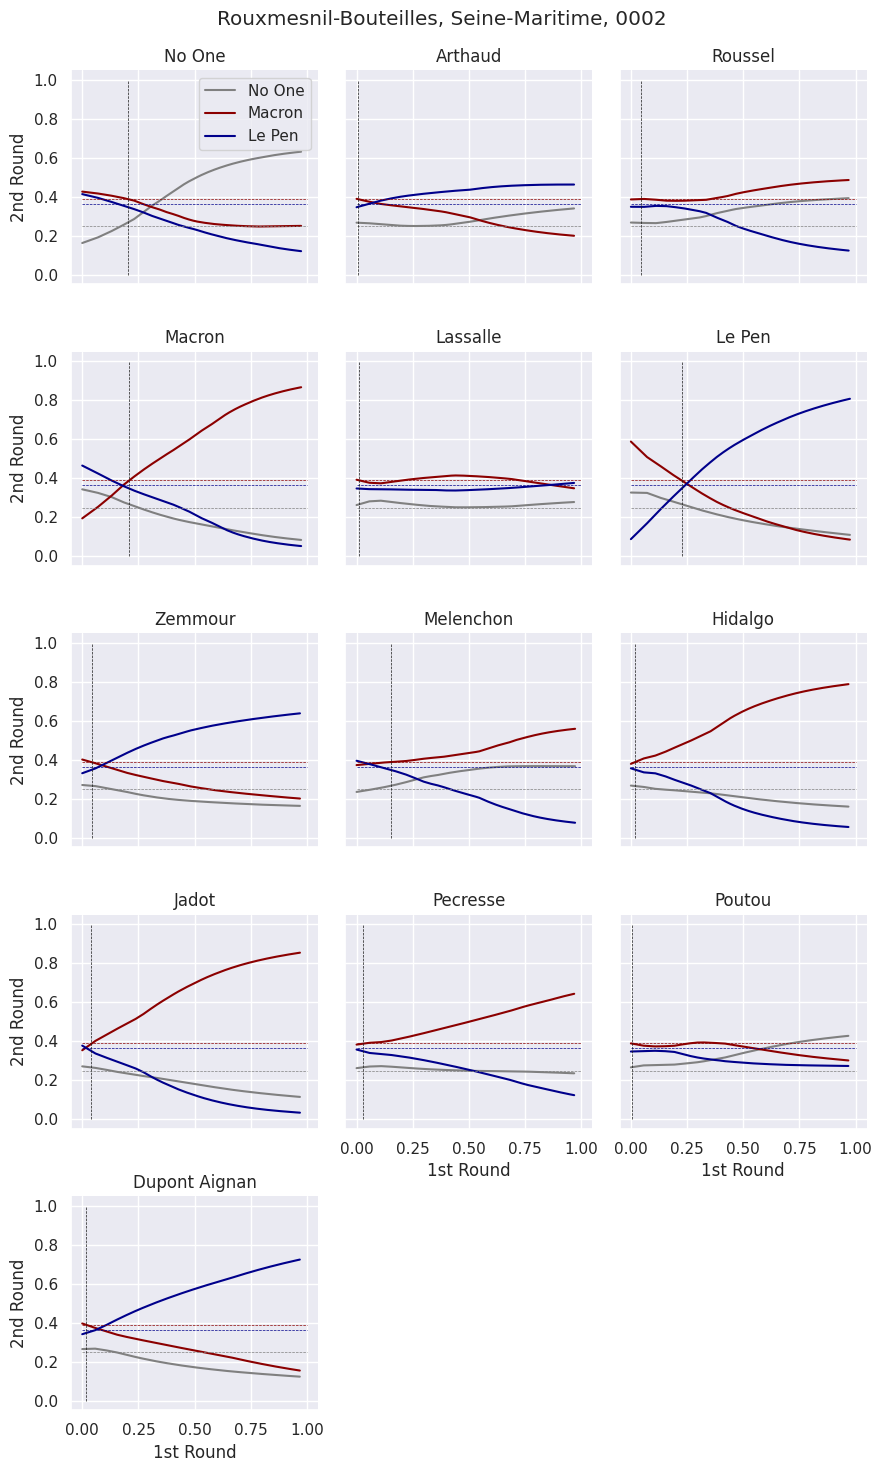

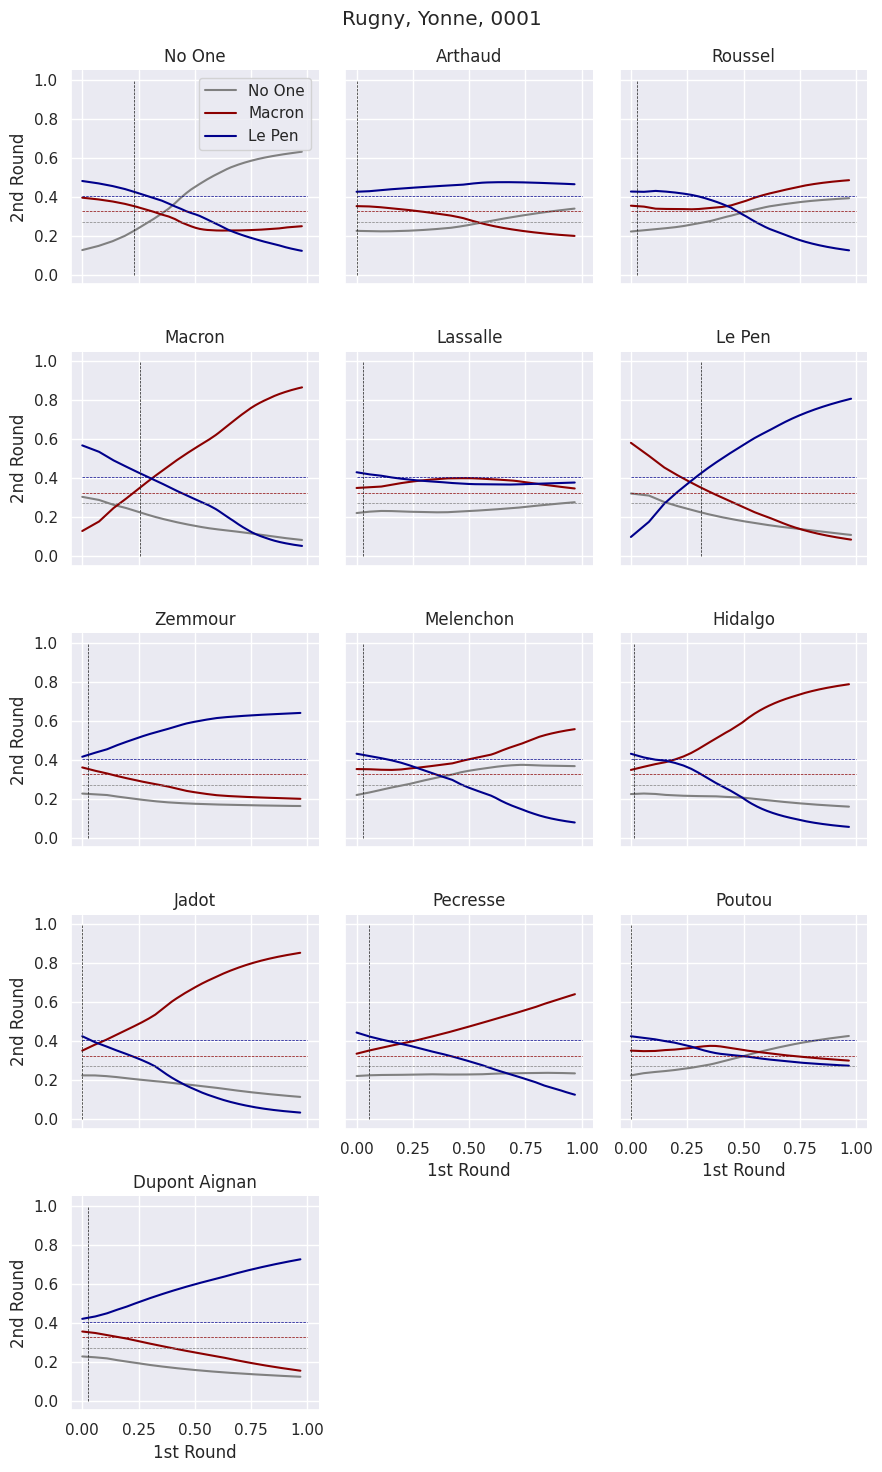

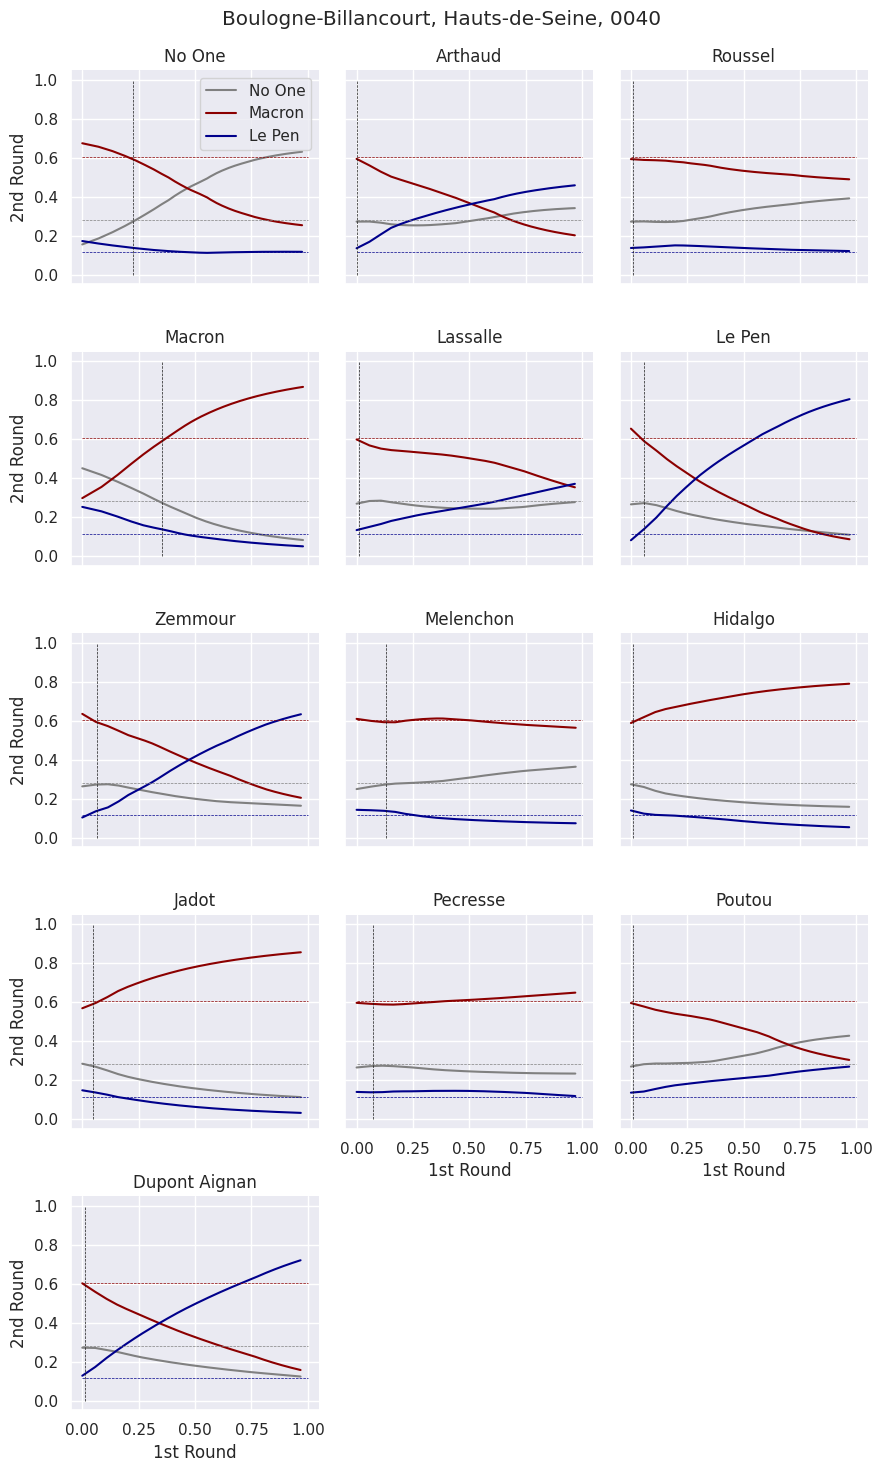

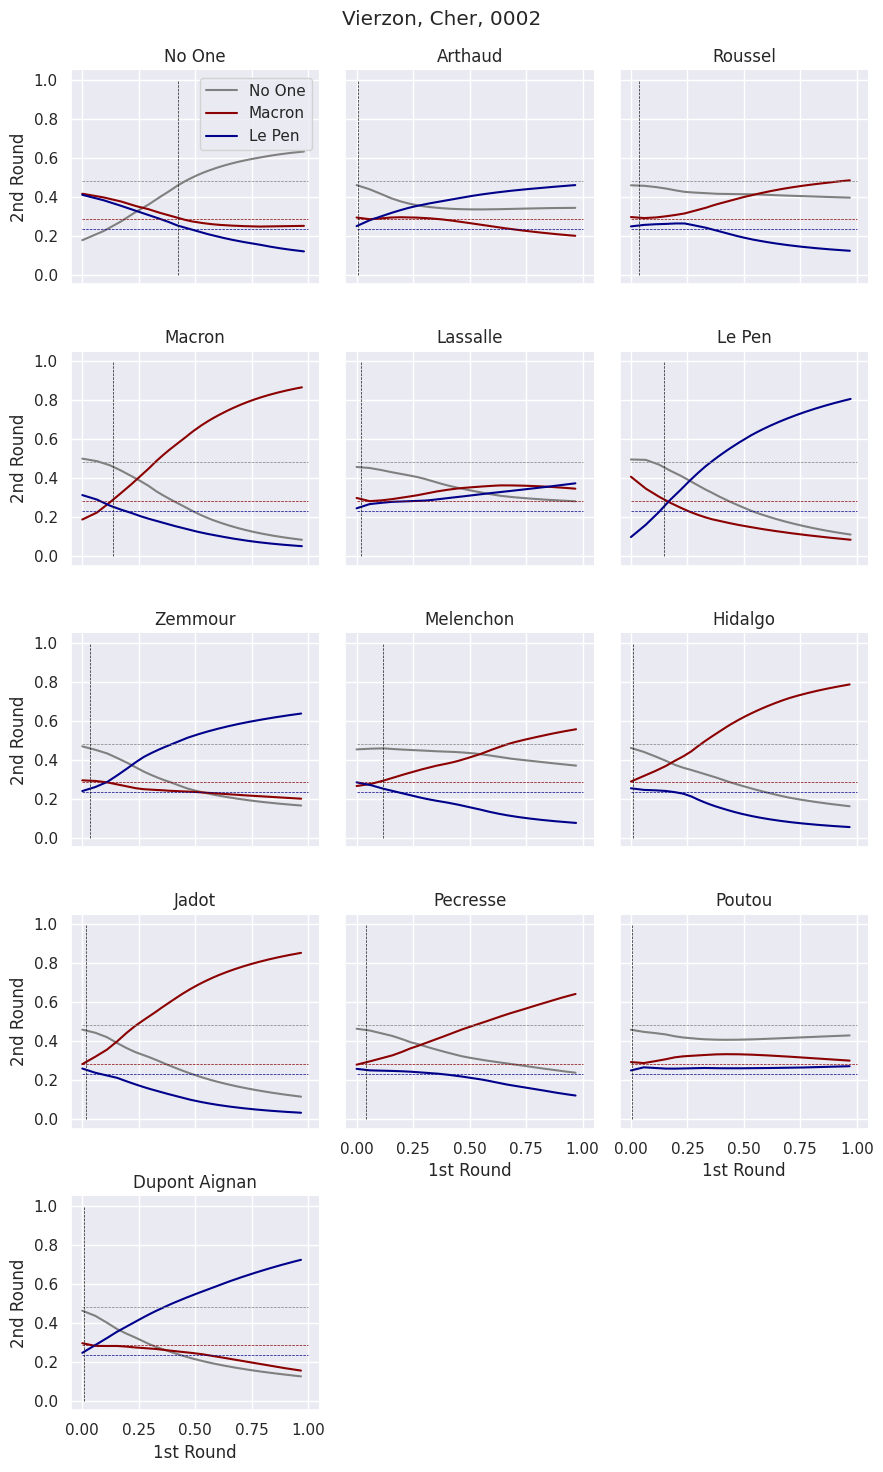

In [18]:
np.random.seed(63)
station_indices = np.random.randint(size=15, low=0, high=prop_t2.shape[0])

for station_index in station_indices:
    new_prop_t2_hat = predict_hypothetical_results(station_index=station_index,
                                                prop_t1=prop_t1,
                                                model=model)
    plot_hypothetical_results(new_prop_t2_hat=new_prop_t2_hat,
                            station_index=station_index,
                            df_t1=df_t1,
                            prop_t1=prop_t1,
                            prop_t2=prop_t2)

## Looking at residuals

There seems to be some structure in the error. 

The model does not predict equally well for every department. In particular, it performs  worse for departments outside of metropolitan France.

In [19]:
prop_t2_all.groupby('CodeDepartement')[
    'Macron_Residual'].median().sort_values(ascending=False).head(25)

CodeDepartement
ZA    0.392739
ZC    0.374716
ZB    0.312633
ZS    0.244380
ZD    0.225920
ZP    0.134251
2B    0.108966
2A    0.102868
ZM    0.101859
ZX    0.094619
ZN    0.088744
70    0.067312
08    0.065328
23    0.062443
55    0.062193
32    0.061707
52    0.061330
58    0.059763
48    0.058195
ZZ    0.057417
09    0.057355
02    0.056800
39    0.056366
10    0.056076
04    0.054672
Name: Macron_Residual, dtype: float32

In [20]:
prop_t2_all.groupby('CodeDepartement')[
    'Le_Pen_Residual'].median().sort_values(ascending=False).head(25)

CodeDepartement
ZA    0.510846
ZB    0.499954
ZC    0.452174
ZS    0.382701
ZD    0.381330
ZW    0.255832
ZP    0.243885
ZZ    0.233937
ZX    0.141020
64    0.074685
75    0.073250
48    0.071398
92    0.070980
65    0.069181
93    0.069084
94    0.068815
42    0.067692
ZM    0.067616
87    0.067347
69    0.065352
21    0.063854
32    0.063322
2B    0.062386
46    0.062126
63    0.060652
Name: Le_Pen_Residual, dtype: float32

In [21]:
prop_t2_all.groupby('CodeDepartement')[
    'No_One_Residual'].median().sort_values(ascending=False).head(25)

CodeDepartement
ZP    0.121281
ZD    0.108066
ZZ    0.091610
52    0.089202
55    0.087380
21    0.087024
70    0.079783
48    0.079013
87    0.078853
71    0.078603
39    0.075817
08    0.075586
63    0.075492
58    0.075301
03    0.074984
25    0.074691
09    0.073951
32    0.072974
46    0.072564
2A    0.072488
15    0.071763
65    0.070521
42    0.069443
23    0.069252
79    0.069092
Name: No_One_Residual, dtype: float32

We also seem to be making higher errors when there are fewer registered voters.

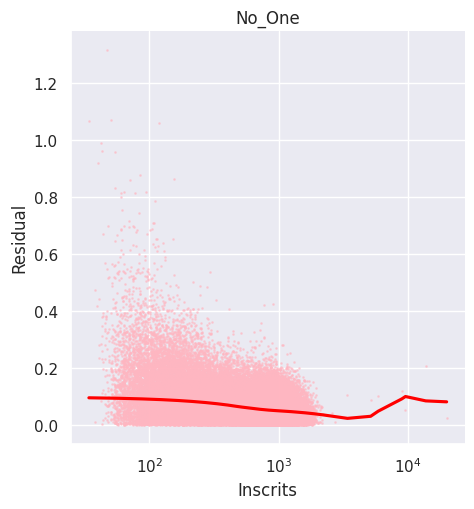

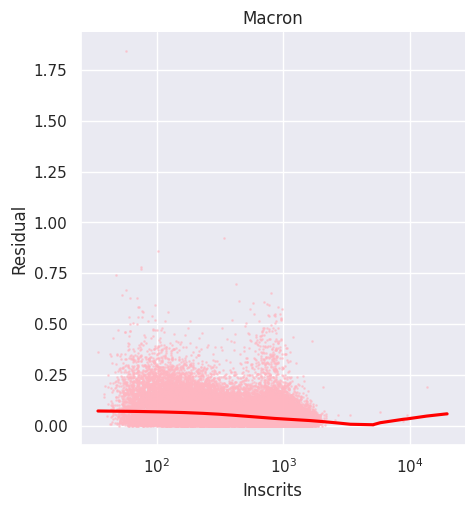

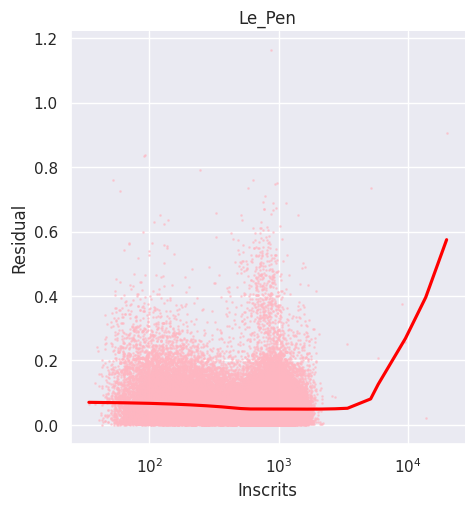

In [22]:
for choice in choices_t2:
    sns.lmplot(
        data=prop_t2_all,
        x='Inscrits',
        y=f'{choice}_Residual',
        line_kws={'color': 'red'},
        scatter_kws={'s': 1, 'color': '#ffb6c1', 'alpha': .5},
        lowess = True)
    plt.xscale("log")
    plt.ylabel("Residual")
    plt.title(choice)
    plt.show()
